In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/EnKF/")

"/media/mat/HDD/EnKF/Project.toml"

In [2]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
using LinearAlgebra
using ProgressMeter
using DifferentialEquations

┌ Info: Recompiling stale cache file /home/mat/.julia/compiled/v1.1/Revise/M1Qoh.ji for Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/mat/.julia/compiled/v1.1/EnKF/oXK06.ji for EnKF [685896a8-a41b-11e9-3419-3315e75b5d74]
└ @ Base loading.jl:1184
┌ Warning: Replacing docs for `EnKF.A :: Union{Tuple{EnsembleState{N,TS}}, Tuple{TS}, Tuple{NS}, Tuple{N}} where TS where NS where N` in module `EnKF`
└ @ Base.Docs docs/Docs.jl:223
┌ Warning: Replacing docs for `EnKF.A :: Union{Tuple{EnsembleState{N,TS}}, Tuple{TS}, Tuple{NS}, Tuple{N}} where TS where NS where N` in module `EnKF`
└ @ Base.Docs docs/Docs.jl:223
┌ Info: Recompiling stale cache file /home/mat/.julia/compiled/v1.1/DifferentialEquations/UQdwS.ji for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1184


In [3]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
clibrary(:colorbrewer)
pyplot()

┌ Info: Recompiling stale cache file /home/mat/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/mat/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


Plots.PyPlotBackend()

We are interested in simulating the Lorenz attractor
            $$\frac{d x_i}{dt} = (x_{i+1} - x_{i-2})x_{i-1} - x_i + F$$ with 
            $F = 8, x_0 = x_{40}, x_{-1} = x_{39}, x_{41} = x_1$ 

Define parameters of the Lorenz attractor

In [102]:
function lorenz95(du,u,p,t)
    
    # first the 3 edge cases: i=1,2,N
    du[1] = (u[2] - u[39])*u[40] - u[1] 
    du[2] = (u[3] - u[40])*u[1] -  u[2]
    du[40] = (u[1] - u[38])*u[39] -  u[40]
    
    for i = 3:39
    du[i] = (u[i+1] - u[i-2])*u[i-1] -u[i] 
    end

    du .+=8.0
end


u0 = rand(40)
tspan = (0.0,40.0)

Δt = 1e-2
T = tspan[1]:Δt:tspan[end]

prob = ODEProblem(lorenz95,u0,tspan)
sol = solve(prob, RK4(), adaptive = false, dt = Δt)

integrator = init(prob, RK4(), adaptive =false, dt = Δt, save_everystep=false)

t: 0.0
u: 40-element Array{Float64,1}:
 0.04091810236233684
 0.393265028410521  
 0.18509898760388133
 0.2689224685512752 
 0.8948222293781651 
 0.5610302807002845 
 0.634355029979494  
 0.3485952509139849 
 0.17390178095606101
 0.9317181244072767 
 0.8004250548923426 
 0.8823795013934446 
 0.6892388117894033 
 ⋮                  
 0.8416055047939441 
 0.6811610336731575 
 0.5324100238208178 
 0.3762555669987864 
 0.5055030634010471 
 0.8957102315097258 
 0.09973333398377937
 0.937155977938225  
 0.3557211514300236 
 0.7221698607717411 
 0.3609883257348483 
 0.4303369284259455 

In [103]:
states = [deepcopy(u0)]

1-element Array{Array{Float64,1},1}:
 [0.0409181, 0.393265, 0.185099, 0.268922, 0.894822, 0.56103, 0.634355, 0.348595, 0.173902, 0.931718  …  0.53241, 0.376256, 0.505503, 0.89571, 0.0997333, 0.937156, 0.355721, 0.72217, 0.360988, 0.430337]

In [104]:
for t in T[1:end-1]
    step!(integrator)
    push!(states, deepcopy(integrator.u))
end

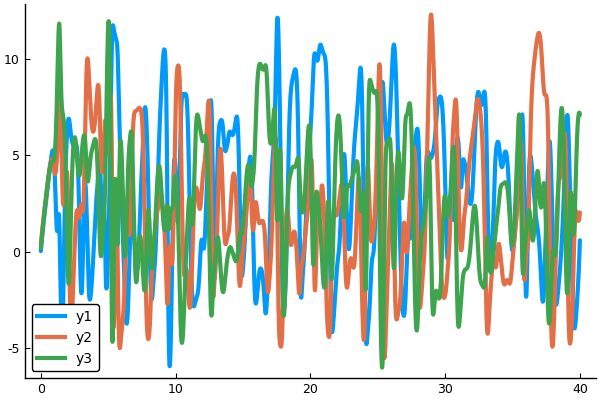

In [105]:
plot(T, hcat(states...)[1,:], linewidth  = 3)
plot!(T, hcat(states...)[2,:], linewidth = 3)
plot!(T, hcat(states...)[3,:], linewidth = 3)

Define propagation function fprop

In [106]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N, TS}) where {N, TS}
    for (i,s) in enumerate(ENS.S)
        
        set_t!(integrator, deepcopy(t))
        set_u!(integrator, deepcopy(s))
        for j=1:50
        step!(integrator)
        end
        ENS.S[i] = deepcopy(integrator.u)

    end
    
    return ENS
end

In [107]:
fprop = PropagationFunction()

PropagationFunction()

Define measurement function m

In [108]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    return s
end

In [109]:
function (::MeasurementFunction)(t::Float64) 
    return I
end

In [110]:
m = MeasurementFunction()

MeasurementFunction()

Define  real measurement function z, always measure the true state but is corrupted by noise ϵ

In [111]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    let s = sol(t)
    fill!(ENS, deepcopy(s))
    end
    return ENS
end

In [112]:
z = RealMeasurementFunction()

RealMeasurementFunction()

Define filtering function

In [113]:
g = FilteringFunction()

FilteringFunction()

Define covariance inflation

In [191]:
A = MultiAdditiveInflation(40, 1.05, MvNormal(zeros(40), 2.0*I))
A = RTPSInflation(0.05)
# A = MultiplicativeInflation(40, 1.05)
# A = RTPSAdditiveInflation(0.75, MvNormal(zeros(40), 1.0*I));
# A = IdentityInflation()

Define noise covariance

In [192]:
ϵ = AdditiveInflation(MvNormal(zeros(40), 1.0*I));

In [193]:
N = 50
NZ = 40
isinflated = true
isfiltered = false
isaugmented = false;

In [194]:
ens = initialize(N, MvNormal(zeros(40), 2.0*I))
estimation_state = [deepcopy(ens.S)]

tmp = deepcopy(u0)
true_state = [deepcopy(u0)]

1-element Array{Array{Float64,1},1}:
 [0.0409181, 0.393265, 0.185099, 0.268922, 0.894822, 0.56103, 0.634355, 0.348595, 0.173902, 0.931718  …  0.53241, 0.376256, 0.505503, 0.89571, 0.0997333, 0.937156, 0.355721, 0.72217, 0.360988, 0.430337]

In [195]:
enkf = ENKF(N, NZ, fprop, A, g, m, z, ϵ, isinflated, isfiltered, isaugmented)

ENKF{50,40}(PropagationFunction(), RTPSInflation(0.05), FilteringFunction(), MeasurementFunction(), RealMeasurementFunction(), AdditiveInflation{40}(IsoNormal(
dim: 40
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)
), true, false, false)

### Ensemble Kalman filter estimation

In [196]:
Δt = 1e-2
Tsub = 0.0:50*Δt:40.0-50*Δt

@showprogress for (n,t) in enumerate(Tsub)

    global ens
#     enkf.f(t, ens)
    t, ens,_ = enkf(t, 50*Δt, ens)
    push!(estimation_state, deepcopy(ens.S))
    

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


$$ \|A\|_p = \left( \sum_{i=1}^n | a_i | ^p \right)^{1/p} $$

In [197]:
s =  hcat(sol(T).u...)
ŝ =  hcat(mean.(estimation_state)...)
ssub =  hcat(sol(Tsub).u...)
norm(ssub - ŝ[:,1:end-1])/norm(ssub)

0.06326741922292507

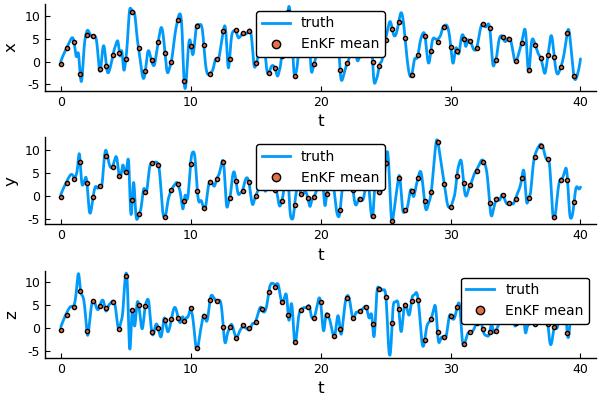

In [198]:
plt = plot(layout = (3, 1), legend = true)
plot!(plt[1], T, s[1,1:end], linewidth = 2, label = "truth")
scatter!(plt[1], Tsub, ŝ[1,1:end-1], linewidth = 2, markersize = 3, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash)

plot!(plt[2], T, s[2,1:end], linewidth = 2, label = "truth")
scatter!(plt[2], Tsub, ŝ[2,1:end-1], linewidth = 2, markersize = 3, label = "EnKF mean", xlabel = "t", ylabel = "y", linestyle =:dash)

plot!(plt[3], T, s[3,1:end], linewidth = 2, label = "truth")
scatter!(plt[3], Tsub, ŝ[3,1:end-1], linewidth = 2, markersize = 3, label = "EnKF mean", xlabel = "t", ylabel = "z", linestyle =:dash)

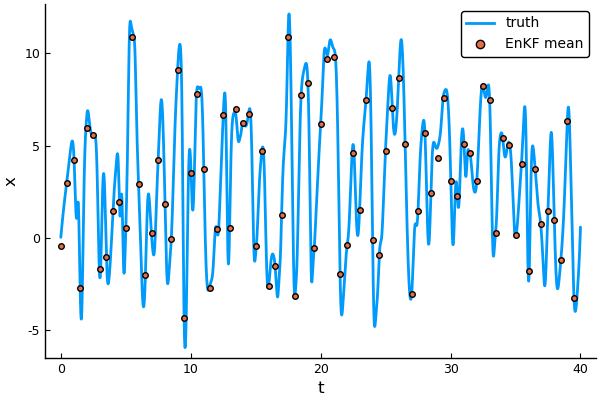

In [201]:
plot(T, s[1,:], linewidth = 2, label = "truth")
# plot!(Tsub, ŝ[1,1:end-1], linewidth = 3, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash)
scatter!(Tsub, ŝ[1,1:end-1], linewidth = 2, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash)